In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

##### Pre-Setting

In [63]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.logging.print_header()

data_path = '/data2/lsg239/PBMC3k/filtered_gene_bc_matrices/hg19/' # where is cellranger output?
result_file = '/data2/lsg239/PBMC3k/results/pbmc3k.h5ad' # where to save? file path + name

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.5.3 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.13.2 pynndescent==0.5.7


##### Data Loading

In [3]:
# read datafile (3 files of cell ranger output) and save as anndata structure
adata = sc.read_10x_mtx(
    path=data_path,
    var_names='gene_symbols',
    cache=True
)

# obs : cells (cell barcodes)
# var : genes
# if using gene_symbol, multiple gene_ids can be mapped to a single gene_symbol. So make it unique
adata.var_names_make_unique()
adata # (2700 cells) x (32738 genes) --> sparse matrix (most values are 0)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
adata.obs.head()

""
AAACATACAACCAC-1
AAACATTGAGCTAC-1
AAACATTGATCAGC-1
AAACCGTGCTTCCG-1
AAACCGTGTATGCG-1


In [5]:
adata.var.head()

,gene_ids
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


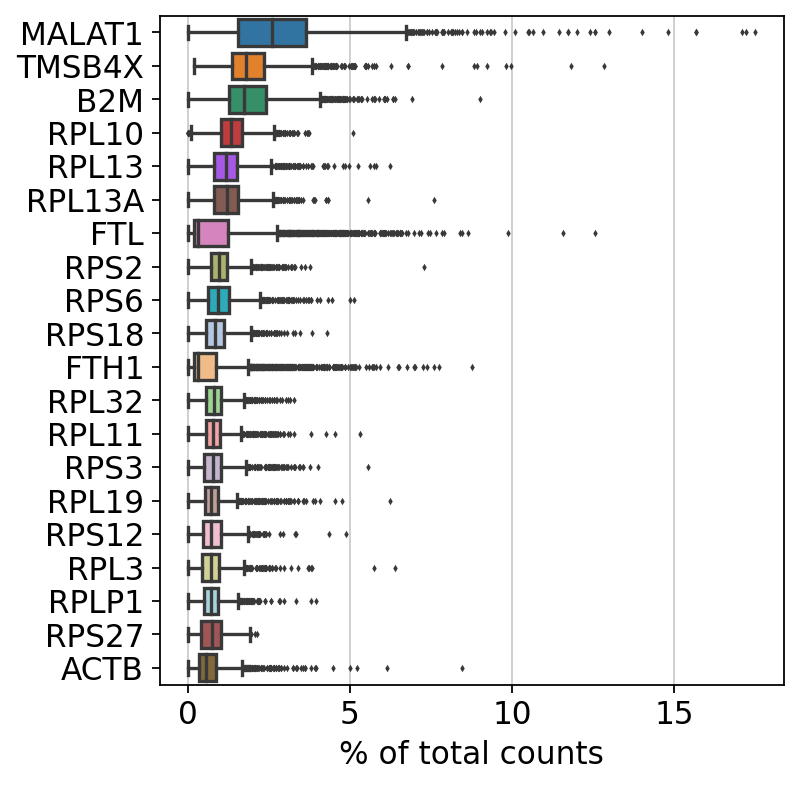

In [6]:
# Exploratory View of Top 20 most expressed genes among entire data
sc.pl.highest_expr_genes(adata, n_top=20) # scanpy.plot.highest_expressed_genes

##### Quality Control

In [7]:
# Quality Control
sc.pp.filter_cells(adata, min_genes=200) # drop cells with less than 200 expressed genes
sc.pp.filter_genes(adata, min_cells=3) # drop genes being expressed in less than 3 cells

adata.var['mt'] = adata.var_names.str.startswith('MT-') # sort out mitochondrial genes --> need to make a sole column to calculate qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=None, inplace=True) # qc_vars : which var to check quality?

In [8]:
adata.obs.head() # adata.obs : cells (pd.DataFrame)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [9]:
adata.var.head() # adata.var : genes (pd.DataFrame)

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0


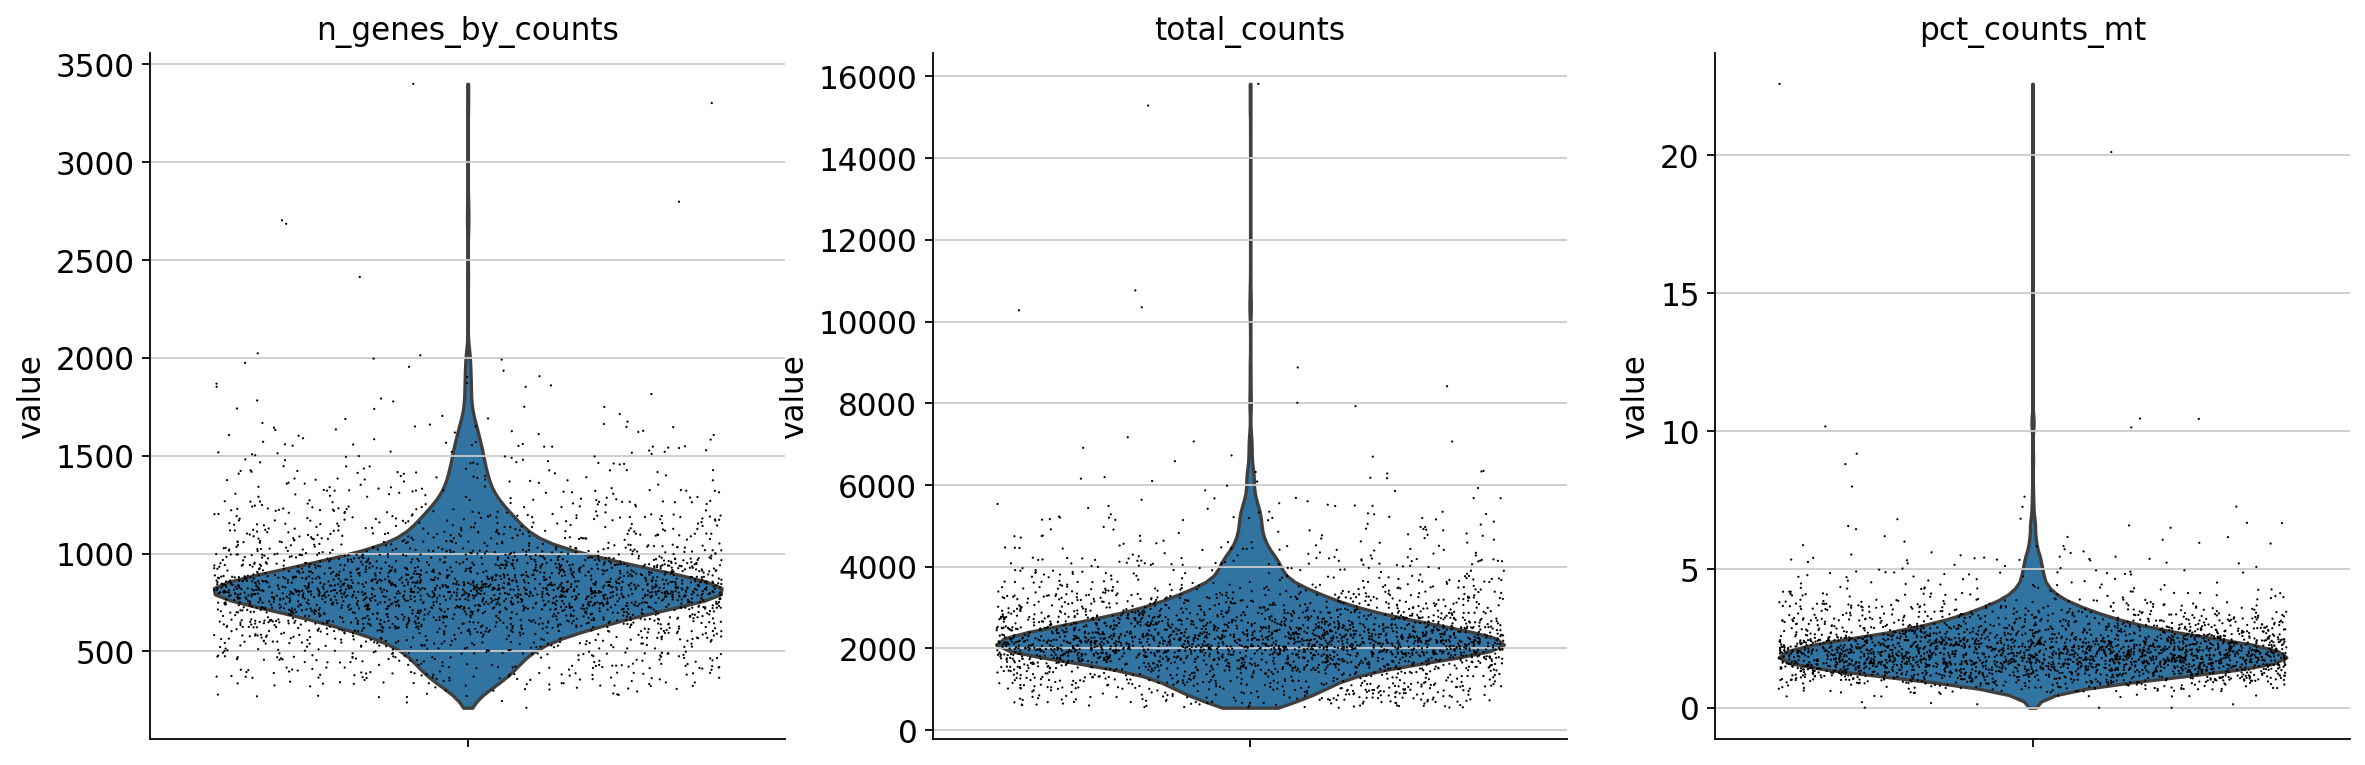

In [10]:
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

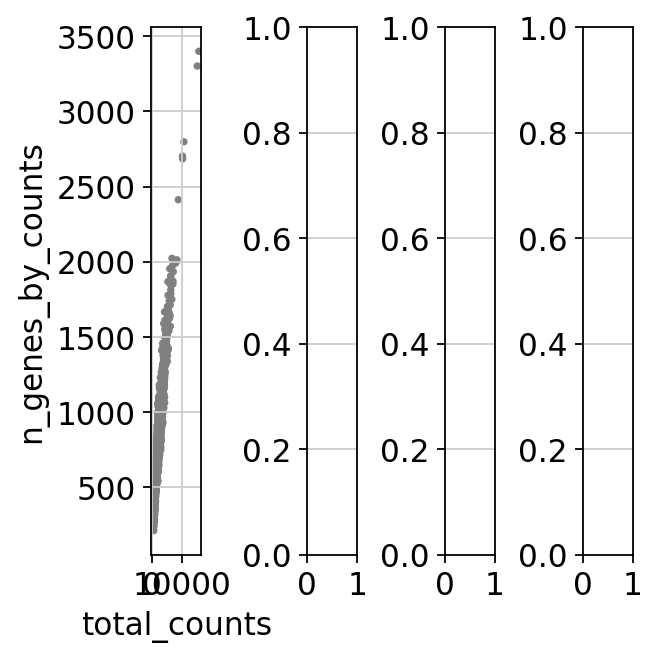

In [14]:
fig, ax = plt.subplots(ncols=4, constrained_layout=True)

sc.pl.scatter(
    adata,
    x='total_counts',
    y='n_genes_by_counts',
    ax=ax[0]
)

sc.pl.scatter(
    adata,
    x='total_counts',
    y='pct_counts_mt',
    ax=ax[2]
)

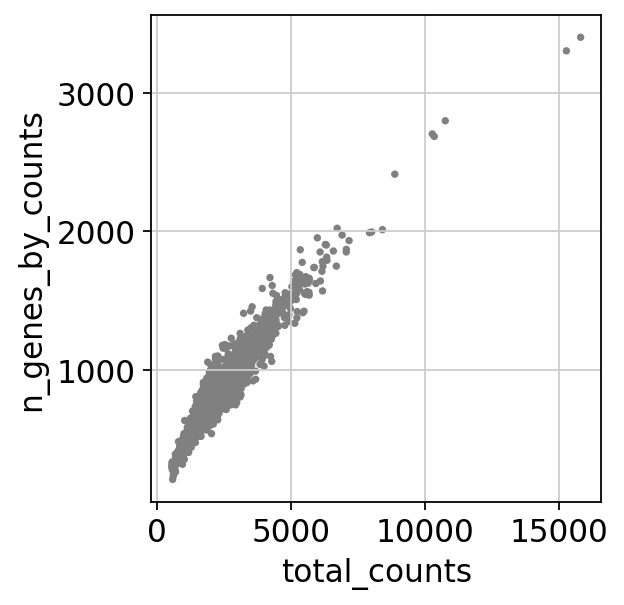

In [15]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

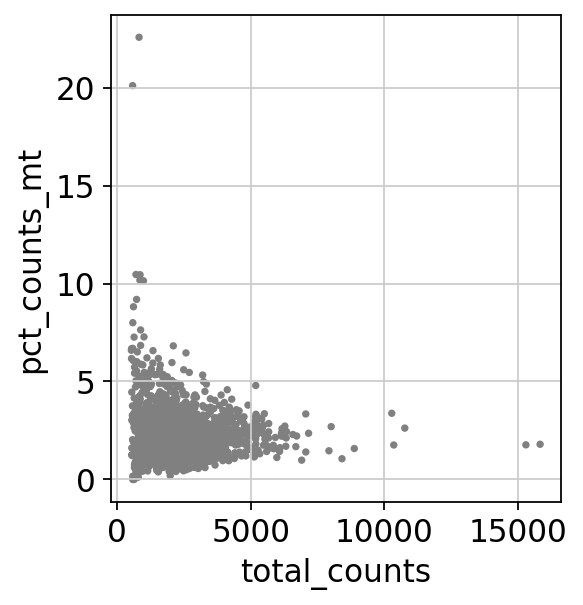

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :] # Maximum gene counts per cell == 2500
adata = adata[adata.obs.pct_counts_mt < 5, :] # Maximum percentage of mitochondrial genes per cell == 5

In [18]:
adata.shape

(2638, 13714)

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/lsg239/.conda/envs/239realm/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [23]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [24]:
adata.var.head()

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0,False,0.013556,1.432845,-0.624328
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0,False,0.004696,1.458631,-0.573416
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0,False,0.005673,1.325459,-0.836359
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0,False,0.002644,0.859264,-1.756848
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0,False,0.027437,1.457477,-0.575693


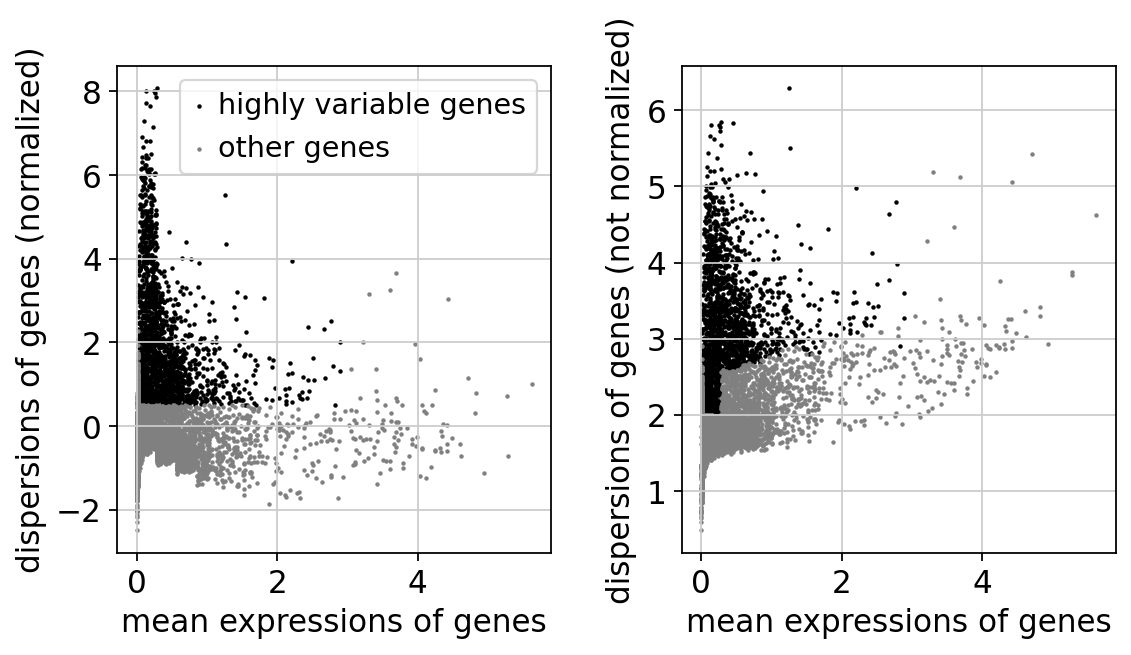

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
adata = adata[:, adata.var.highly_variable]

In [28]:
adata.shape

(2638, 1838)

In [29]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [30]:
sc.pp.scale(adata, max_value=10)

##### Dimensionality Reduction

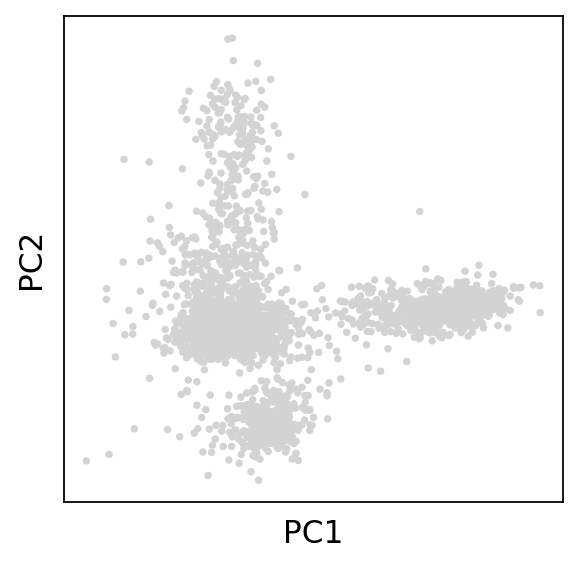

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

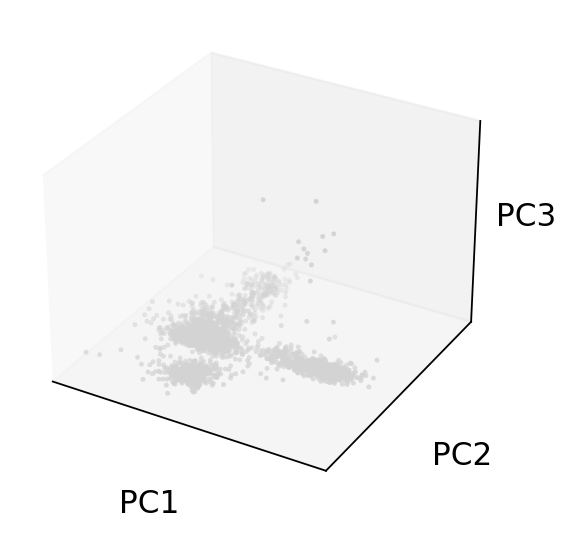

In [33]:
sc.pl.pca(adata, projection='3d')

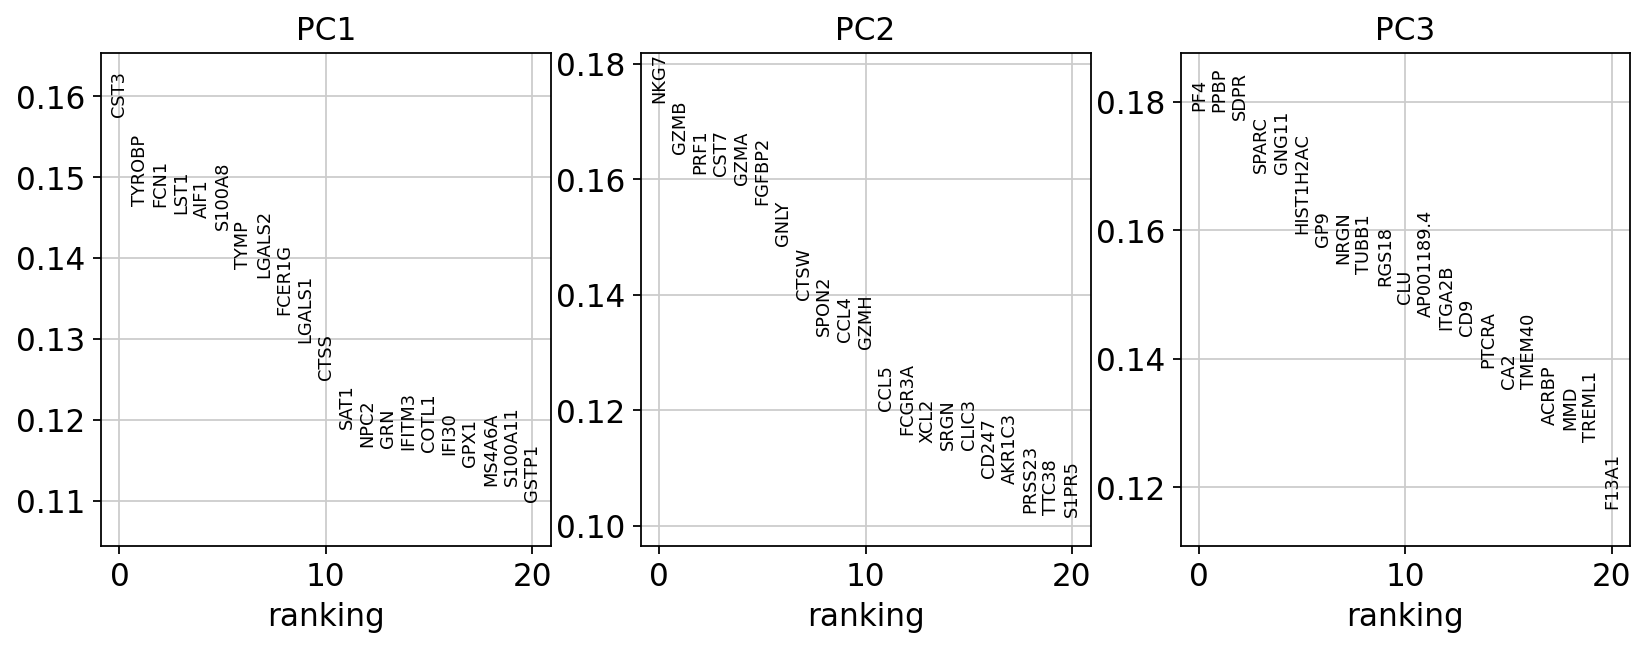

In [43]:
sc.pl.pca_loadings(adata, include_lowest=False, n_points=20)

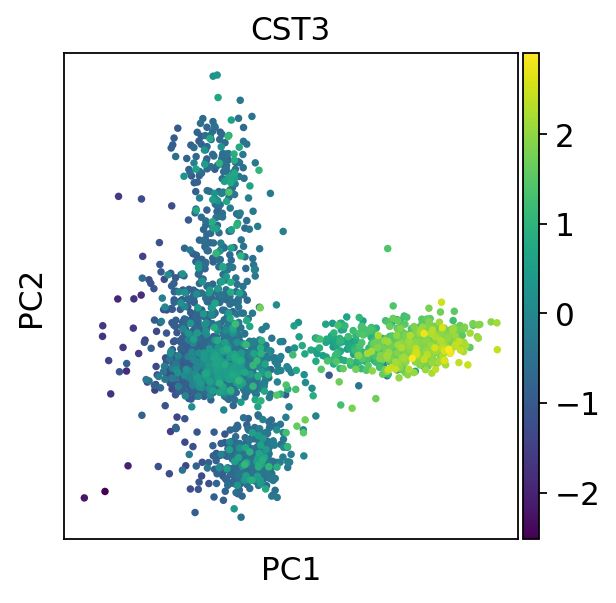

In [35]:
sc.pl.pca(adata, color='CST3')

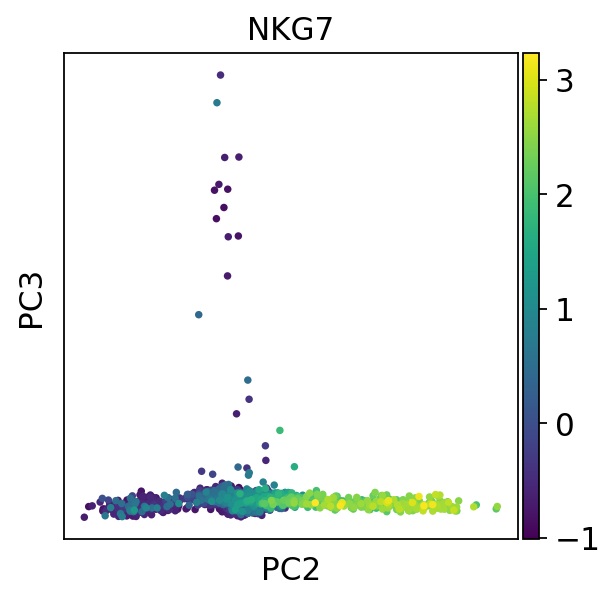

In [44]:
sc.pl.pca(adata, color='NKG7', components="2, 3")

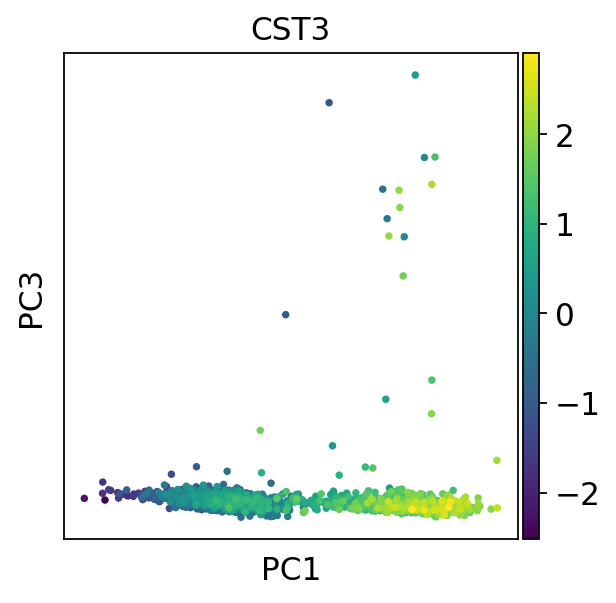

In [37]:
sc.pl.pca(adata, color='CST3', components='1, 3')

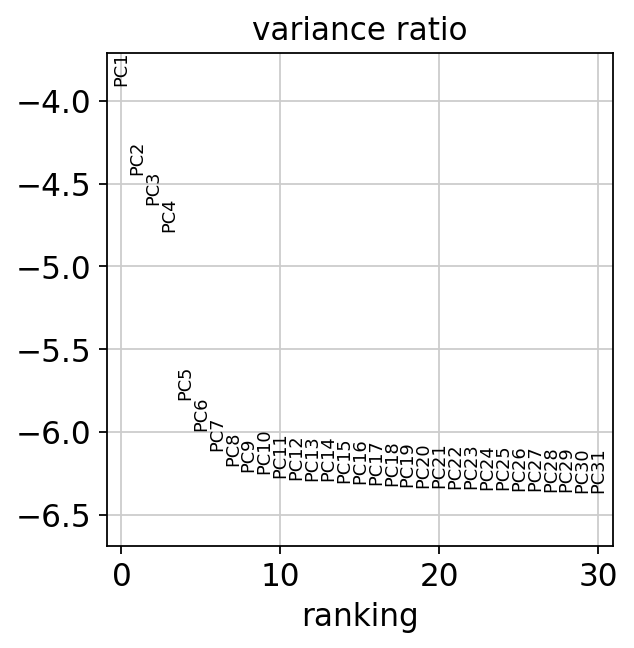

In [45]:
sc.pl.pca_variance_ratio(adata, log=True)

In [46]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

In [47]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [51]:
adata.var.head()

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
TNFRSF4,ENSG00000186827,155,False,155,0.077407,94.259259,209.0,True,0.277410,2.086050,0.665406,-3.764522e-10,0.424481
CPSF3L,ENSG00000127054,202,False,202,0.094815,92.518519,256.0,True,0.385194,4.506987,2.955005,-3.135005e-10,0.460416
ATAD3C,ENSG00000215915,9,False,9,0.009259,99.666667,25.0,True,0.038252,3.953486,4.352607,5.825179e-12,0.119465
C1orf86,ENSG00000162585,501,False,501,0.227778,81.444444,615.0,True,0.678283,2.713522,0.543183,3.841088e-10,0.685145
RER1,ENSG00000157916,608,False,608,0.298148,77.481481,805.0,True,0.814813,3.447533,1.582528,8.755421e-11,0.736050


In [55]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([32.11043  , 18.718634 , 15.60733  , 13.235289 ,  4.802269 ,
        3.98593  ,  3.5262349,  3.2334428,  3.1212184,  3.075263 ,
        2.9980748,  2.9595215,  2.9517894,  2.9442508,  2.9138684,
        2.8990293,  2.880678 ,  2.8646793,  2.8430636,  2.8357499,
        2.8314204,  2.8182354,  2.8035498,  2.799986 ,  2.788953 ,
        2.778103 ,  2.7705767,  2.760224 ,  2.753862 ,  2.7459557,
        2.7371838,  2.7341259,  2.722202 ,  2.7123103,  2.702478 ,
        2.700047 ,  2.683852 ,  2.6790504,  2.6769068,  2.6739945,
        2.6648538,  2.6573107,  2.651177 ,  2.6417747,  2.6329703,
        2.6295207,  2.6245286,  2.6183755,  2.6180024,  2.6018658],
      dtype=float32), 'variance_ratio': array([0.02012818, 0.01173363, 0.00978334, 0.00829644, 0.00301027,
       0.00249855, 0.00221039, 0.00202686

In [58]:
pd.DataFrame(adata.X).head()

,0,1,2,3,4,5,6,7,8,9,...,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837
0,-0.171470,-0.280812,-0.046677,-0.475169,-0.544024,4.928497,-0.038028,-0.280573,-0.341788,-0.195361,...,-0.226570,-0.236269,-0.102943,-0.222116,-0.312401,-0.121678,-0.521229,-0.098269,-0.209095,-0.531203
1,-0.214582,-0.372653,-0.054804,-0.683391,0.633951,-0.334837,-0.045589,-0.498264,-0.541914,-0.209017,...,-0.317531,2.568868,0.007155,-0.445372,1.629285,-0.058662,-0.857163,-0.266844,-0.313146,-0.596654
2,-0.376888,-0.295085,-0.057527,-0.520972,1.332648,-0.309362,-0.103108,-0.272526,-0.500799,-0.220228,...,-0.302938,-0.239801,-0.071774,-0.297857,-0.410920,-0.070431,-0.590720,-0.158656,-0.170876,1.379000
3,-0.285241,-0.281735,-0.052227,-0.484929,1.572680,-0.271825,-0.074552,-0.258875,-0.416752,-0.208471,...,-0.262978,-0.231807,-0.093818,-0.247770,2.552079,-0.097402,1.631684,-0.119462,-0.179120,-0.505669
4,-0.256484,-0.220394,-0.046800,-0.345859,-0.333409,-0.208122,-0.069514,5.806440,-0.283112,-0.199355,...,-0.202237,-0.176765,-0.167350,-0.098665,-0.275836,-0.139482,-0.310095,-0.006877,-0.109614,-0.461946


In [59]:
adata.X.shape

(2638, 1838)

In [60]:
adata.shape

(2638, 1838)

In [61]:
sc.tl.umap(adata)

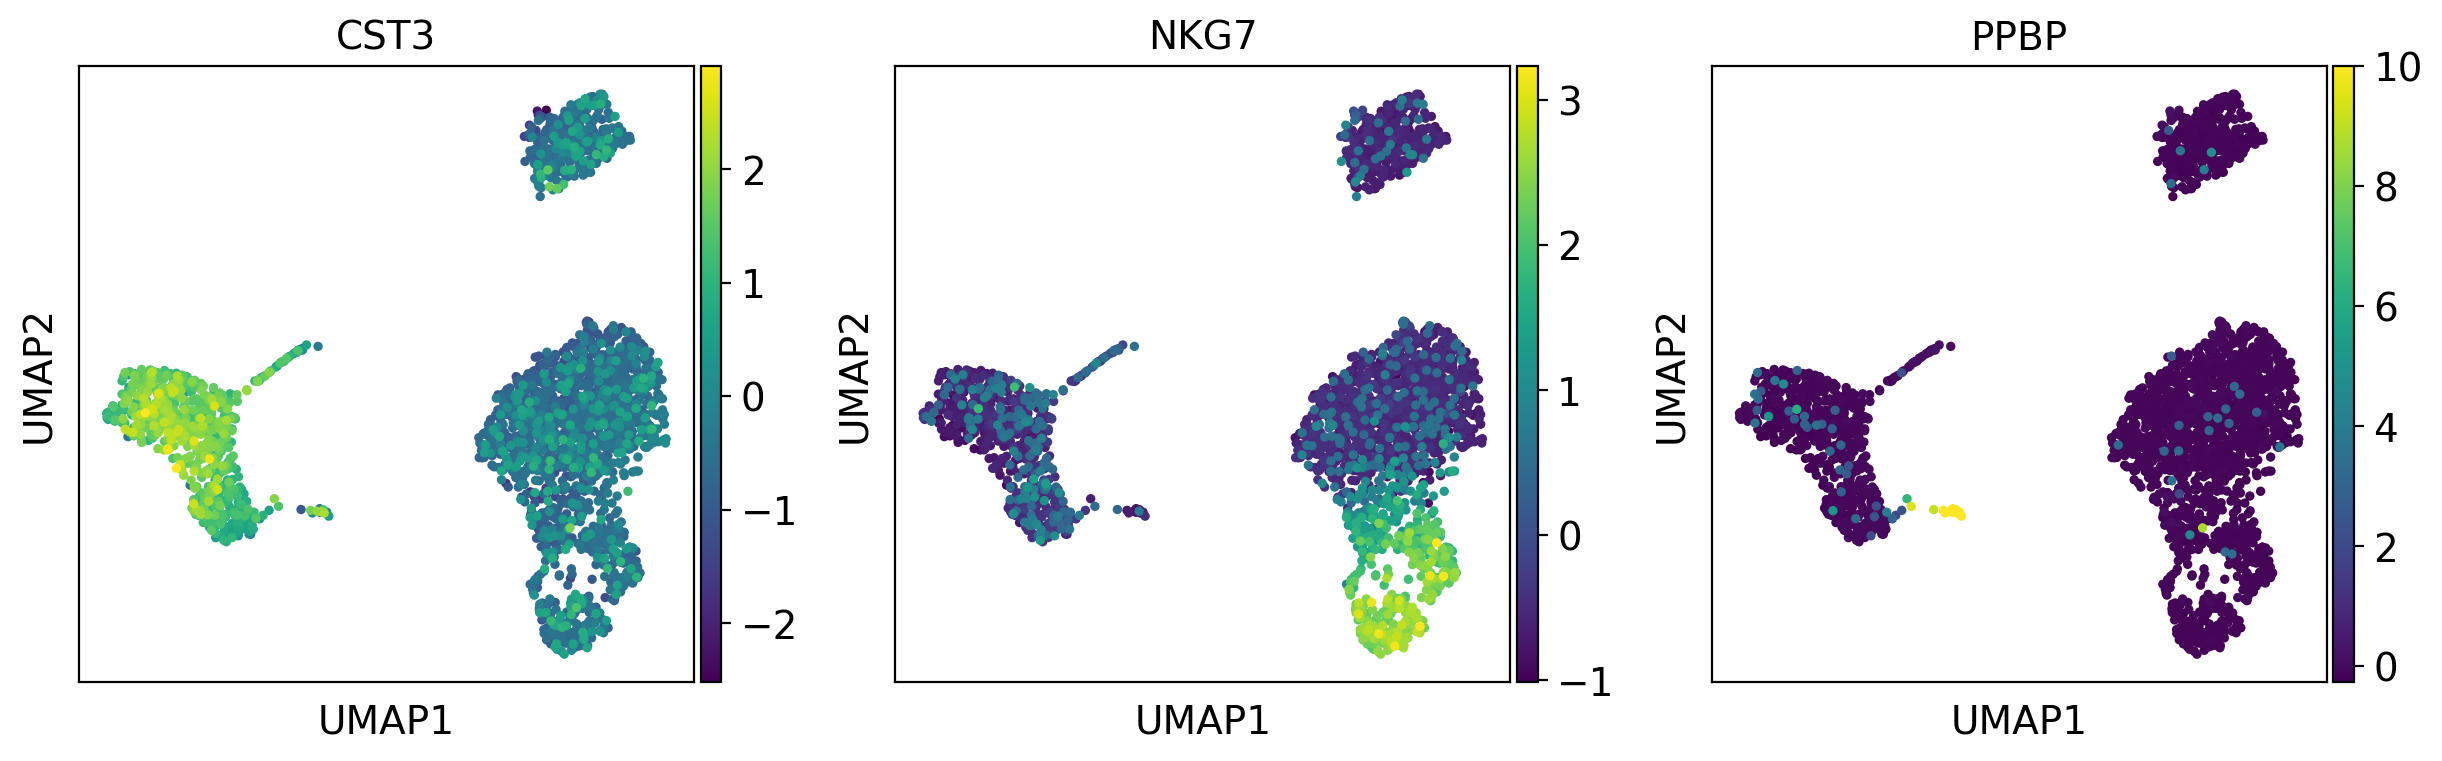

In [64]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [65]:
test_adata = adata.copy()

In [67]:
sc.tl.paga(test_adata)

ValueError: You need to run `tl.leiden` or `tl.louvain` to compute community labels, or specify `groups='an_existing_key'`